# Random forest machine learning classification of leaf microCT data
#### Semi-automated segmentation of 3D microCT data into multiple classes: (1) background, (2) veins, (3) mesophyll cells, (4) bundle sheath tissue, and (5) intercellular airspace

#### Open questions:
* Incorporate thresholding based on two user provided ranges for the grid and phase reconstructed images
* Try adding more convolution filters to GenerateFL2 function.  E.g. difference of gaussians, membrane projection filter, etc.
* Try automated segmentation of palisade and mesophyll tissue
* Test on other tissue types, e.g. epidermal cells, when they are clearly visible in scans. E.g. in conifers and cycads
* What happens when there is embolism in the vascular tissue?

#### Matt's changes:
* Added function to RFLeafSeg.py that corrects dimension after scaling, specifcally for label_stack
* Fixed a problem with GenerateFL2 function in RFLeafSeg.py that would, in some cases, throw an error due to incompatible array dimensions; see dist_edge_FL for correction
* See ML_microCT folder for an interactive version of this program that can be completely executed from the command line...see ML_microCT_inst for instructions on use of ML_microCT
#### Matt's questions:
* What image type is first loaded in? I though it was a stack of '.tif' image files of type 'float32'. If so, then when are we converting these image stacks to 8-bit? Does this happen when we threshold the images?

#### Last edited by: M. Jenkins 
#### Date: 12/09/2017

In [16]:
# Import libraries
import os
import sklearn as skl
import skimage.io as io
from skimage import img_as_int, img_as_ubyte, img_as_float
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import RFLeafSeg # reload(RFLeafSeg)
from scipy import misc
from skimage.util import invert
from skimage import transform
from sklearn.metrics import confusion_matrix

### Image Loading and Pre-processing

In [17]:
# Set path to tiff stacks
filepath = "../../v_champ/"

In [18]:
# Read gridrec, phaserec, and label tif stacks
gridrec_stack = io.imread(filepath + "gridrec.tif")
phaserec_stack = io.imread(filepath + "phaserec.tif")
#Optional image loading, if you need to rotate images
#label_stack = np.rollaxis(io.imread(filepath + 'label_stack.tif'),2,0)
label_stack = io.imread(filepath + "label_stack.tif")
#Invert my label_stack, uncomment as needed
label_stack = invert(label_stack)

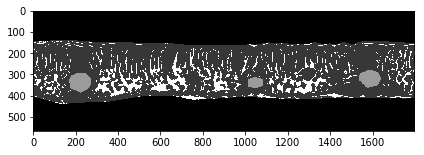

In [4]:
%matplotlib inline
io.imshow(label_stack[0,:,:])

In [5]:
# # Generate/load local thickness stack
# # Uncomment as needed

# Generate binary thresholded image for input to local thickness function
# Set grid and phase threshold values for segmenting low and high absorption regions
# I typically use Fiji to subjectively and visually determine the 'best' value for each
Th_grid = -12.08 # grid rec threshold value
Th_phase = 0.31 # phase rec threshold value
GridPhase_Bin = RFLeafSeg.Threshold_GridPhase(gridrec_stack, phaserec_stack,Th_grid,Th_phase)

# # Invert image
# GridPhase_Bin_invert = invert(GridPhase_Bin)

# # Downsample to 25%
# GridPhase_Bin_invert = transform.rescale(GridPhase_Bin_invert, 0.25)

# local_thick = RFLeafSeg.local_thickness(GridPhase_Bin_invert)
# local_thick_upscale = transform.rescale(local_thick, 4, mode='reflect')

# # Write as a tif file
# io.imsave('local_thick_upscale.tif', local_thick_upscale)

# Load local thickness stack, if already generated
localthick_stack = io.imread('local_thick_upscale.tif')

In [6]:
print(label_stack.shape)
print(localthick_stack.shape)

(2, 566, 1796)
(300, 568, 1796)


In [7]:
# Match array dimensions to correct for resolution loss due to downsampling when generating local thickness
gridrec_stack, localthick_stack = RFLeafSeg.match_array_dim(gridrec_stack,localthick_stack)
phaserec_stack, localthick_stack = RFLeafSeg.match_array_dim(phaserec_stack,localthick_stack)
label_stack, localthick_stack = RFLeafSeg.match_array_dim_label(label_stack,localthick_stack)

In [8]:
print(label_stack.shape)
print(localthick_stack.shape)

(2, 566, 1796)
(300, 566, 1796)


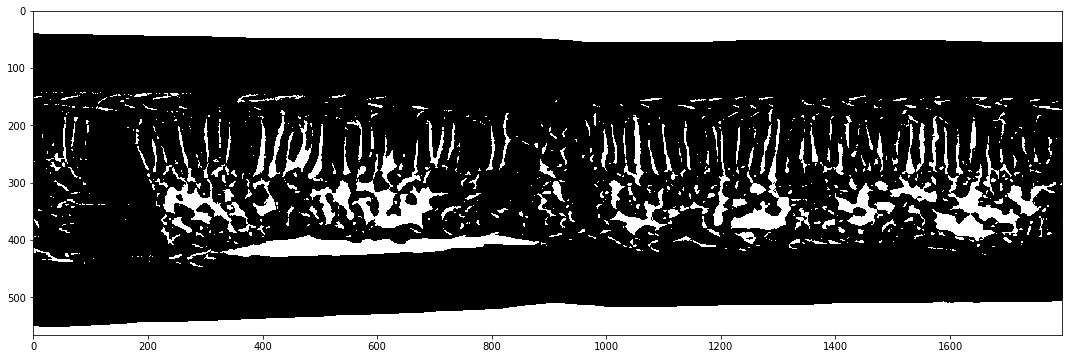

In [9]:
# Plot thresholded image for QC
%matplotlib inline
fig = plt.figure(figsize = (15,15))
io.imshow(GridPhase_Bin[100,:,:])

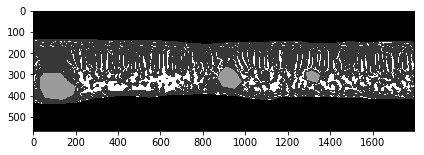

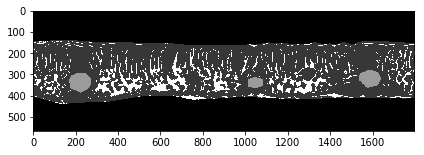

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


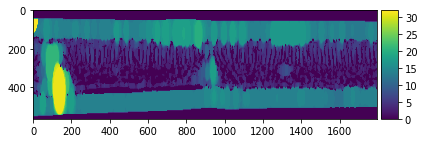

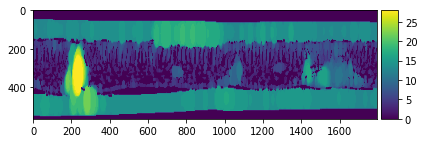

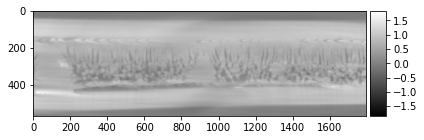

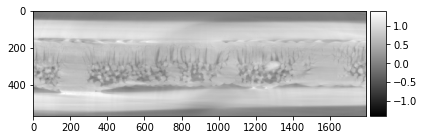

In [10]:
# Plot some of the images for QC
for i in [1,0]:
    io.imshow(label_stack[i,:,:])
    io.show()

for i in [45,245]:    
    io.imshow(localthick_stack[i,:,:])
    io.show()
    
for i in [45,245]:    
    io.imshow(phaserec_stack[i,:,:], cmap='gray')
    io.show()

In [11]:
# Check shapes of stacks to ensure that they match
print(gridrec_stack.shape)
print(phaserec_stack.shape)
print(label_stack.shape)
print(localthick_stack.shape)

(300, 566, 1796)
(300, 566, 1796)
(2, 566, 1796)
(300, 566, 1796)


In [12]:
# Define image subsets for training and testing
gridphase_train_slices_subset = [45] # 99 for training of Vitis champ.
gridphase_test_slices_subset = [245] # 55, 160 and 248 for testing of Vitis champ.
label_train_slices_subset = [1] # corresponding slice from the label stack
label_test_slices_subset = [0] # corresponding slice from the label stack

In [ ]:
import scipy.ndimage as spim

dist_edge = np.ones(gridrec_stack.shape)
dist_edge[:,(0,1,2,3,4,gridrec_stack.shape[1]-4,gridrec_stack.shape[1]-3,gridrec_stack.shape[1]-2,gridrec_stack.shape[1]-1),:] = 0
dist_edge = transform.rescale(dist_edge, 0.25,clip=True, preserve_range=True)
dist_edge_FL = spim.distance_transform_edt(dist_edge)
dist_edge_FL = np.multiply(transform.rescale(dist_edge_FL,4,clip=True,preserve_range=True),4)

if dist_edge_FL.shape[1]>gridrec_stack.shape[1]:
    dist_edge_FL = dist_edge_FL[:,0:gridrec_stack.shape[1],:]


print(dist_edge_FL.shape)

In [13]:
# Generate training and testing feature layer array
FL_train_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, localthick_stack, gridphase_train_slices_subset, "transverse")
FL_test_transverse = RFLeafSeg.GenerateFL2(gridrec_stack, phaserec_stack, localthick_stack, gridphase_test_slices_subset, "transverse")

/Users/mattjenkins1/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [14]:
# Load and encode label image vectors
Label_train_transverse = RFLeafSeg.LoadLabelData(label_stack, label_train_slices_subset, "transverse")
Label_test_transverse = RFLeafSeg.LoadLabelData(label_stack, label_test_slices_subset, "transverse")

In [15]:
# Check the dimensions of the feature array and label vector to ensure that they are the same dimensions
print(FL_train_transverse.shape)
print(Label_train_transverse.shape)

(1016536, 36)
(1016536,)


### Train model

In [ ]:
# Define Random Forest classifier parameters and fit model
rf_transverse = RandomForestClassifier(n_estimators=50, verbose=True, oob_score=True, n_jobs=4, warm_start=False) #, class_weight="balanced")
rf_transverse = rf_transverse.fit(FL_train_transverse, Label_train_transverse)

In [ ]:
# Save model to disk # This can be a pretty large file -- ~2 Gb
# import pickle
# filename = 'RF_Vitus_champ_model.sav'
# pickle.dump(rf_transverse, open(filename, 'wb'))

#load the model from disk
#rf = pickle.load(open(filename, 'rb'))

### Examine prediction metrics on training dataset

In [ ]:
# Print out of bag precition accuracy
print('Our OOB prediction of accuracy for is: {oob}%'.format(oob=rf_transverse.oob_score_ * 100))

In [ ]:
# Print feature layer importance
# See RFLeafSeg module for corresponding feature layer types
feature_layers = range(0,len(rf_transverse.feature_importances_))
for fl, imp in zip(feature_layers, rf_transverse.feature_importances_):
    print('Feature_layer {fl} importance: {imp}'.format(fl=fl, imp=imp))
#print('none')

### Predict single slices from test dataset

In [ ]:
# Make prediction on test set
class_prediction_transverse = rf_transverse.predict(FL_test_transverse)
class_prediction_transverse_prob = rf_transverse.predict_proba(FL_test_transverse)

In [ ]:
# Generate confusion matrix for transverse section
pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
# Generate normalized confusion matrix for transverse section
pd.crosstab(Label_test_transverse, class_prediction_transverse, rownames=['Actual'], colnames=['Predicted'], normalize='index')

In [ ]:
class_prediction_transverse_prob.shape

In [ ]:
# Reshape arrays for plotting images of class probabilities, predicted classes, observed classes, and feature layer of interest
prediction_transverse_prob_imgs = class_prediction_transverse_prob.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    5),
    order="F")
prediction_transverse_imgs = class_prediction_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
observed_transverse_imgs = Label_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2]),
    order="F")
FL_transverse_imgs = FL_test_transverse.reshape((
    -1,
    label_stack.shape[1],
    label_stack.shape[2],
    36),
    order="F")

In [ ]:
# Plot images of class probabilities, predicted classes, observed classes, and feature layer of interest
%matplotlib inline
for i in range(0,prediction_transverse_imgs.shape[2]):
    io.imshow(prediction_transverse_prob_imgs[i,:,:,3], cmap="RdYlBu")
    io.show()
    io.imshow(observed_transverse_imgs[i,:,:])
    io.show()
    io.imshow(prediction_transverse_imgs[i,:,:])
    io.show()
    io.imshow(phaserec_stack[260,:,:], cmap="gray")
    io.show()
    io.imshow(FL_transverse_imgs[0,:,:,26], cmap="gray")
    io.show()

### Predict all slices in 3D microCT stack

In [ ]:
# Predict all slices in 3D microCT stack
RFPredictCTStack_out = RFLeafSeg.RFPredictCTStack(rf_transverse,gridrec_stack, phaserec_stack, LocalThickness_CellVeins,"transverse")

### Calculate performance metrics

In [ ]:
# Performance metrics
test_slices = (99,160,248)
label_slices = (1,2,3)

# Generate absolute confusion matrix
confusion_matrix = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Generate normalized confusion matrix
confusion_matrix_norm = pd.crosstab(RFPredictCTStack_out[test_slices,:,:].ravel(order="F"),
                               label_stack[label_slices,:,:].ravel(order="F"),
                               rownames=['Actual'], colnames=['Predicted'])

# Total accuracy
print(np.diag(confusion_matrix).sum()/RFPredictCTStack_out[test_slices,:,:].sum())

# Class precision
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,1), "precision")

# Class recall
print(np.diag(confusion_matrix)/np.sum(confusion_matrix,0), "recall")

### Save segmented and classified stack as TIFF file

In [ ]:
# Save classified stack
io.imsave('Vitis_champ_Predicted.tif',img_as_int(RFPredictCTStack_out/4))